# JAX에서 상태를 유지하는 연산

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb)

이번 섹션은 JAX에서 상태를 유지하는 프로그램의 구현을 어떻게 제한하는지 살펴보겠습니다.

## 동기 부여

> "상태"란 특정 시점에 가지고 있는 값들을 의미합니다. 예를 들어 클래스의 객체는 메소드 뿐만이 아니라 속성값을 통해 "상태"를 가질 수 있습니다.

머신러닝 프로그램에서의 "상태"란 다음과 같은 것을 말합니다.
* 모델 파라미터
* 옵티마이저의 상태
* 자체적으로 상태를 가지고 있는 레이어, 예를 들어 [배치 정규화](https://en.wikipedia.org/wiki/Batch_normalization) 레이어가 있습니다.

JAX가 수행하는 몇몇 변환(대부분 `jax.jit`)에는 제한들이 있습니다. 특히 `jax.jit`에 의해 변환된 함수는 부작용이 없어야 합니다. 왜냐하면  어떠한 부작용이라도, 파이썬으로 작성된 코드를 컴파일하는 과정에서 오직 한번만 실행되기 때문입니다. 이러한 부작용은 컴파일된 함수가 이후 실행될 때 실행되지 않습니다.

프로그램의 "상태"를 바꾸는 것은 부작용에 해당합니다. 부작용을 허용하지 않는다면, 어떻게 모델의 파라미터, 옵티마이저의 상태, 상태를 가지고 있는 레이어들을 업데이트 할 수 있을까요? 이 코랩이 자세하게 설명하겠지만, 빠르게 답변하자면 답은 [함수형 프로그래밍](https://en.wikipedia.org/wiki/Functional_programming)입니다.

## 간단한 예제: 카운터

간단하게, 상태를 유지하는 프로그램으로 `Counter`를 보겠습니다.

In [ ]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


`n` 속성은 `count` 메서드를 연속적으로 호출할 때 `Counter`의 상태를 유지합니다 `n` 속성은 `count`함수의 부작용으로 값이 수정됩니다.

이때 `count` 메서드를 더 빠르게 사용하기 위해, `jax.jit`으로 `count`메소드를 변환한다고 해보겠습니다. (이 예제에서는, 많은 이유로 인해 실제로 속도가 빨라 지진 않습니다. 그러나 JIT 컴파일을 수행하면서, 파라미터를 업데이트해야 하는 간단한 모델로 간주 할 수 있습니다.)

In [ ]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


오 이런! `Counter`가 잘 작동하지 않았습니다. 이것은 아래의 부작용 코드 때문입니다.
```
self.n += 1
```
위 코드는 한번만 실행되며(JAX가 `count` 메소드를 컴파일 할 때), 컴파일된 메소드를 호출할때는 실행되지 않습니다. 게다가, `count`의 반환 값은 `count`의 인수에 의존하지 않기 때문에, 처음에 1을 반환한 후 `fast_count`를 호출하면 항상 1을 반환할 것입니다. 이건 원하는 바가 아닙니다. 그러면 어떻게 고칠 수 있을까요?

## 해결법: 명시적 상태

위의 카운터에서 문제가 됐됐던 부분은 `count` 메소드가 반환하는 값이 인자에 의존하지 않기 때문에, 컴파일 과정에서 반환값이 상수로 고정 되기 때문입니다. 그러나 반환값은 상수가 아니라 "상태"에 따라 바뀌어야 합니다. 그렇다면면 "상태"를 메소드의 인자로 사용하면 어떨까요?

In [ ]:
from typing import Tuple

CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


새로운 버전의 `CounterV2`에서는 `n`을 `count`메소드의 인자로 옮겼고, 반환값으로 새로운, 업데이트된 "상태"를 같이 반환하도록 하였습니다. 이 카운터를 사용하기 위해서는, 이제 "상태"를 클래스 외부에서 명시적으로 관리할 필요가 있습니다. 하지만 그 대가로, `jax.jit`을 이 카운터에 잘 적용할 수 있습니다.

In [ ]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


## 일반적 정책

이제 같은 작업을 적용하여 상태를 유지하는 메소드를 상태를 유지하지 않는 메소드로 바꿀 수 있습니다. 상태를 유지하는 메소드가 있는 클래스의 형태는 다음과 같고

```python
class StatefulClass

  state: State

  def stateful_method(*args, **kwargs) -> Output:
```

변환한, 상태를 유지하지 않는 메소드는 다음과 같습니다.

```python
class StatelessClass

  def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

이것은 일반적인 [함수형 프로그래밍](https://en.wikipedia.org/wiki/Functional_programming) 패턴이자, 모든 JAX 프로그램이 "상태"를 다루는 방식입니다. 

그리고 클래스 메소드를 상태를 유지하지 않도록 작성하면, 클래스의 필요성이 떨어집니다. 단지 `stateless_method`만 있어도 되며, 그렇기 때문에 클래스는 아무런 역할을 하지 않습니다. 이것이 객체지향 프로그래밍이 프로그래머가 프로그램의 "상태"를 이해하도록 도울 수 있는 이유입니다.

이 경우 `CounterV2` 클래스는 `CounterState`를 사용하는 모든 함수를 하나의 위치로 모으는 네임스페이스에 지나지 않습니다. 독자를 위한 문제: 여러분은 이것을 위해 클래스를 유지하는 것이 맞다고 생각하나요?


사실, 우리는 이러한 정책의 예제를 [Random Numbers section](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05-random-numbers.ipynb)에서 `jax.random`이라는 JAX pseudo-randomness API를 통해 이미 보았습니다. 난수생성기의 "상태"를 상태를 유지하는 클래스로 관리하는 넘파이와는 달리,  JAX는 프로그래머가 직접적으로 난수생성기의 "상태"를 사용하도록 합니다.(PRNGKey)

## 간단한 예제: 선형 회귀

이제 이러한 정책을 선형 회귀와 경사하강법으로 학습하는 간단한 머신러닝 모델에 적용해보겠습니다.

이 예제에서는 "상태" 중에서도 모델 파라미터만 다루겠습니다. 그러나 일반적으로 옵티마이저 상태, 배치정규화 레이어의 통계치 등과 같은 많은 종류의 "상태"가 JAX 함수에 사용되는 것을 볼 수 있습니다.

예제의 `update` 함수를 유의깊게 보세요.

In [ ]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

`update`함수에서 수동으로 `params`를 입력받고 반환하는 것을 볼 수 있습니다.

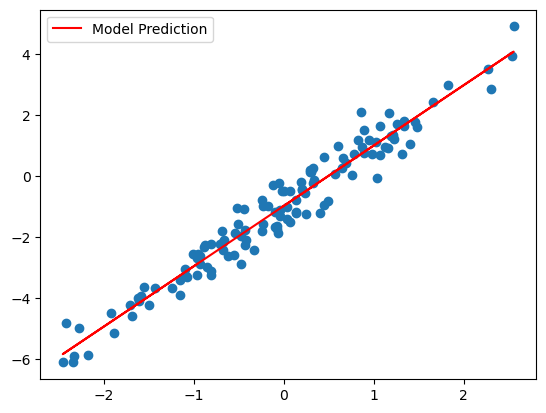

In [ ]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

## 더 나아가서

위에서 설명한 정책은 JIT 컴파일되는 JAX 프로그램이 어떻게 "상태"를 다루는지 보여줍니다.

수동으로 파라미터를 다루는 것이 위 예제처럼 두개의 파라미터라면 괜찮겠지만, 만약 신경망과 같이 여러 층으로 이루어져있다면 어떨까요? 아마 다음과 같은 2가지를 걱정할 것입니다.

1) 신경망의 forward 과정을 따라 반복하면서 모든 파라미터를 수동으로 초기화해야 합니까?

2) "상태"가 전달되는 과정을 수동으로 전부 연결해야하나요?

세부 사항은 다루기 까다로울 수 있지만, 이러한 문제를 처리하기 위한 라이브러리의 예제가 있습니다. 
[JAX Neural Network Libraries](https://github.com/google/jax#neural-network-libraries) 문서를 참고하세요.